<a href="https://colab.research.google.com/github/FelixFat/slz_detection/blob/master/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# Install required libs

!pip3 install albumentations
!pip3 install segmentation-models

# Loading dataset

**FloodNet Dataset**:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 600 pixels height and 800 pixels width.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/FloodNet_dim'

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train', 'train-org-img')
y_train_dir = os.path.join(DATA_DIR, 'train', 'train-label-img')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'val-org-img')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'val-label-img')

x_test_dir = os.path.join(DATA_DIR, 'test', 'test-org-img')
y_test_dir = os.path.join(DATA_DIR, 'test', 'test-label-img')

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {
        'Background': 0,
        'Building-flooded': 1,
        'Building-non-flooded': 2,
        'Road-flooded': 3,
        'Road-non-flooded': 4,
        'Water': 5,
        'Tree': 6,
        'Vehicle': 7,
        'Pool': 8,
        'Grass': 9
        }
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (288, 384))
        mask = cv2.resize(mask, (288, 384))
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [ ]:
CLASSES = [
    'Background',
    'Building-flooded',
    'Building-non-flooded',
    'Road-flooded',
    'Road-non-flooded',
    'Water',
    'Tree',
    'Vehicle',
    'Pool',
    'Grass'
]

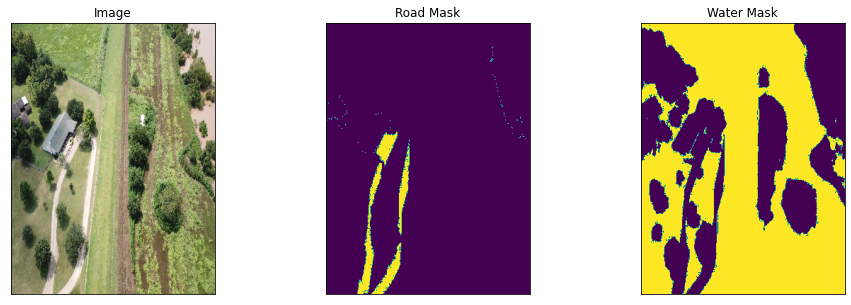

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[17] # get some sample

visualize(
    image=image, 
    road_mask=mask[..., 4].squeeze(),
    water_mask=mask[..., 9].squeeze(),
)

### Augmentations

Augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=384, min_width=384, always_apply=True, border_mode=0),
        A.RandomCrop(height=384, width=384, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 48"""
    test_transform = [
        A.PadIfNeeded(384, 384)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.8/dist-packages/albument

(384, 384, 3) (384, 384, 3)


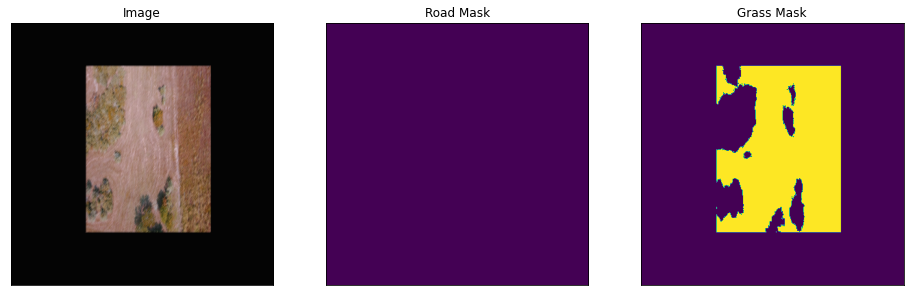

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['Road-non-flooded', 'Grass'], augmentation=get_training_augmentation())

image, mask = dataset[42] # get some sample

print(image.shape, mask.shape)

visualize(
    image=image, 
    road_mask=mask[..., 0],
    grass_mask=mask[..., 1],
)

# Segmentation model training

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'resnet50'
BATCH_SIZE = 16
CLASSES = [
    'Road-non-flooded',
    'Grass'
]
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = len(CLASSES) + 1
activation = 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (Road-non-flooded: 1.; Grass: 2.; Background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./floodnet_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
90/90 [==============================] - 229s 2s/step - loss: 0.5137 - iou_score: 0.2720 - f1-score: 0.3772 - val_loss: 0.5865 - val_iou_score: 0.2988 - val_f1-score: 0.3524 - lr: 1.0000e-04
Epoch 2/40
90/90 [==============================] - 67s 745ms/step - loss: 0.4316 - iou_score: 0.3341 - f1-score: 0.4505 - val_loss: 0.4667 - val_iou_score: 0.4527 - val_f1-score: 0.5400 - lr: 1.0000e-04
Epoch 3/40
90/90 [==============================] - 67s 746ms/step - loss: 0.3755 - iou_score: 0.3742 - f1-score: 0.4939 - val_loss: 0.3934 - val_iou_score: 0.4960 - val_f1-score: 0.5869 - lr: 1.0000e-04
Epoch 4/40
90/90 [==============================] - 68s 749ms/step - loss: 0.3363 - iou_score: 0.4080 - f1-score: 0.5252 - val_loss: 0.3480 - val_iou_score: 0.5190 - val_f1-score: 0.6054 - lr: 1.0000e-04
Epoch 5/40
90/90 [==============================] - 67s 745ms/step - loss: 0.3227 - iou_score: 0.4147 - f1-score: 0.5339 - val_loss: 0.3260 - val_iou_score: 0.5458 - val_f1-score: 0.6307

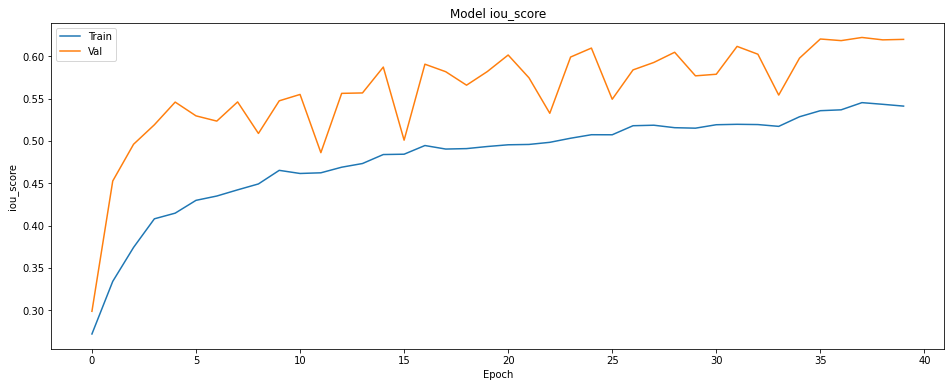

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(16, 6))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

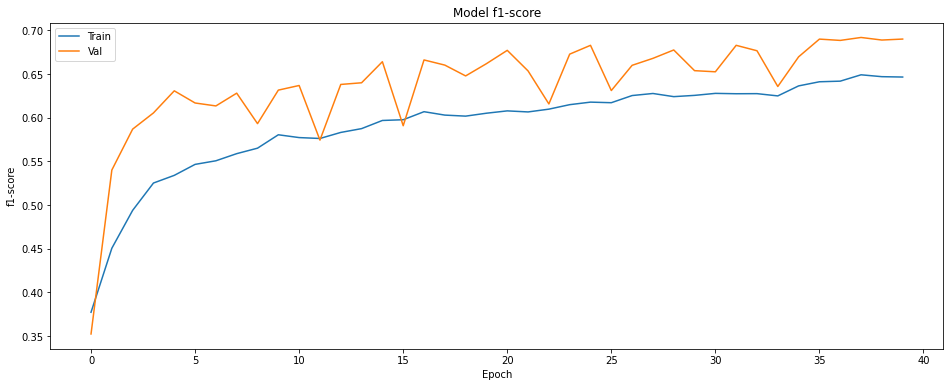

In [ ]:
# Plot training & validation f1_score values
plt.figure(figsize=(16, 6))
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

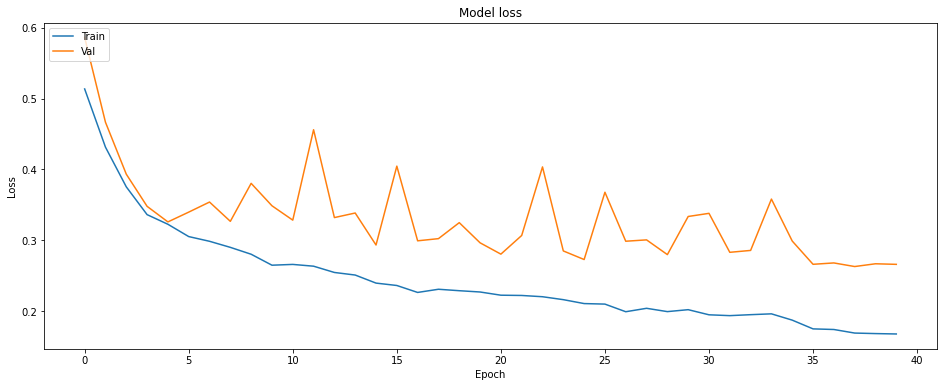

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('floodnet_model.h5') 

In [ ]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

448/448 [==============================] - 399s 891ms/step - loss: 0.2824 - iou_score: 0.6017 - f1-score: 0.6730
Loss: 0.28241
mean iou_score: 0.60172
mean f1-score: 0.673


# Visualization of results on test dataset

1/1 [==============================] - 0s 18ms/step
(384, 384, 3)


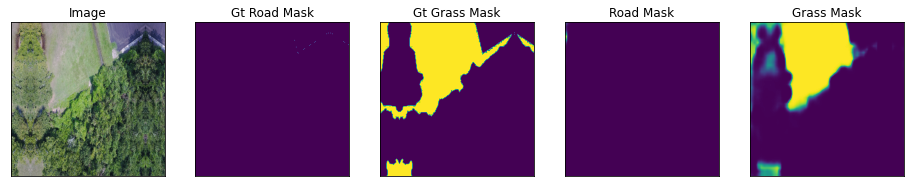

1/1 [==============================] - 0s 17ms/step
(384, 384, 3)


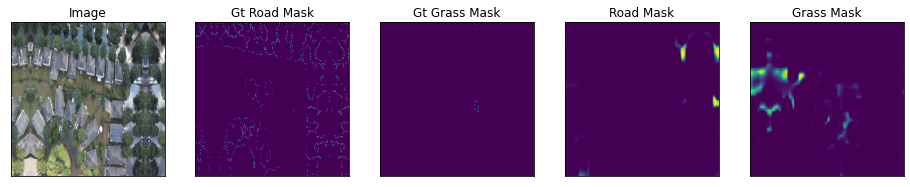

1/1 [==============================] - 0s 18ms/step
(384, 384, 3)


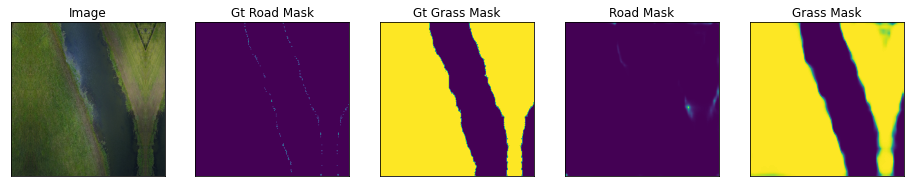

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    im, gt_mask = test_dataset[i]
    image = np.expand_dims(im, axis=0)
    pr_mask = model.predict(image)
    
    print(pr_mask.squeeze().shape)

    visualize(
        image=im,
        gt_road_mask=gt_mask[..., 0],
        gt_grass_mask=gt_mask[..., 1],
        road_mask=pr_mask.squeeze()[..., 0],
        grass_mask=pr_mask.squeeze()[..., 1],
    )